# Import packages

In [5]:
import pandas as pd
import sys
sys.path.append('../')

from aqc_utils.molecule import molecule
from aqc_utils.slurm_manager import slurm_manager
from aqc_utils.helper_classes import slurm_status
from dft_descriptors import prepocessing as pp
import logging
logging.basicConfig(level=logging.INFO)

# Initialize the slurm manager

Slurm manager is going to manage what jobs you have currently running, or created. It caches your information, so you can kill the notebook, turn-off your computer, go on vacation, and pick it up later. It will remember which jobs you haven't retrieved from the cluster, etc.

Note: it won't ask you for login unless you execute a method that requires remote access

In [6]:
sm=slurm_manager(user='jschleinitz', host='hermite.chimie.ens.fr')
sm.connect()

INFO:aqc_utils.slurm_manager:Creating connection to hermite.chimie.ens.fr as jschleinitz
INFO:paramiko.transport:Connected (version 2.0, client OpenSSH_8.2p1)
INFO:paramiko.transport:Authentication (password) successful!
INFO:aqc_utils.slurm_manager:Connected to hermite.chimie.ens.fr as jschleinitz is True.


# Provide smiles string(s)
and copy into them into my_smiles variable. It's a list of strings (a Python list can be of any size), the smiles are extracted for the csv resulting form the step 2 numbering the molecules.

In [7]:
react_nb = pd.read_csv("../data_csv/Data_test10222021.csv", sep=',')
import numpy as np
from rdkit import Chem
df = pd.read_csv('../data_csv/Data_test10222021.csv', sep = ',')
df = df[df['Ligand effectif'].notna()]

In [8]:
unik_lig = [pp.dict_ligand[i] for i in np.unique(df["Ligand effectif"])]
can_unik_lig = np.unique([Chem.CanonSmiles(smi) for smi in unik_lig])
my_smiles = can_unik_lig
can_unik_lig
# determine if ligand is NHC, Phosphine, Diphosphine or other
def lig_type(list_lig):
    lig_type = []
    for smi in list_lig:
        m = Chem.MolFromSmiles(smi)
        if m.HasSubstructMatch(Chem.MolFromSmiles('N[C]N')):
            typ = 'NHC'
            if m.HasSubstructMatch(Chem.MolFromSmiles('P')):
                typ = 'mixed'
        elif m.HasSubstructMatch(Chem.MolFromSmiles('P')):
            typ = 'Phos'
            if len(m.GetSubstructMatches(Chem.MolFromSmiles('P'))) == 2:
                typ = 'DiPhos'
                if len(m.GetSubstructMatches(Chem.MolFromSmiles('P'))) > 2:
                    typ = 'mixed Phos'
        else:
            typ = 'other'
        lig_type.append(typ)
    return lig_type
phos = [can_unik_lig[i] for i in range(len(can_unik_lig)) if lig_type(can_unik_lig)[i] == 'Phos']
phos

['C1=CC(P(C2C=CC=C2)C2C=CC=C2)C=C1',
 'C1CCC(P(C2CCCCC2)C2CCCCC2)CC1',
 'C1CCC(P(C2CCCCC2)C2CCCCC2)CC1.CC(C)(C)N1C=CN(C(C)(C)C)C1',
 'C1CCC(P(C2CCCCC2)C2CCCCC2)CC1.CC(C)c1cccc(C(C)C)c1N1C=CN(c2c(C(C)C)cccc2C(C)C)C1',
 'C1CCC(P(C2CCCCC2)C2CCCCC2)CC1.[CH]1[CH][CH][C](P(c2ccccc2)c2ccccc2)[CH]1.[CH]1[CH][CH][C](P(c2ccccc2)c2ccccc2)[CH]1.[Fe]',
 'CC(C)(C)N1C=CN(C(C)(C)C)C1.c1ccc(P(c2ccccc2)c2ccccc2)cc1',
 'CC(C)(C)P(C(C)(C)C)C(C)(C)C',
 'CC(C)(C)P(C1CCCCC1)C1CCCCC1',
 'CC(C)(C)P(c1ccccc1-c1ccccc1)C(C)(C)C',
 'CC(C)CP(CC(C)C)CC(C)C',
 'CC(C)Oc1cccc(OC(C)C)c1-c1ccccc1P(C1CCCCC1)C1CCCCC1',
 'CC(C)P(C(C)C)C(C)C',
 'CC(C)P(C(C)C)C(Nc1ccccc1-n1nc(-c2ccccc2)cc1-c1ccccc1)c1ccccc1',
 'CC(C)c1cc(C(C)C)c(-c2cc(-c3c(C(C)C)cc(C(C)C)cc3C(C)C)cc(P(C3CCCC3)C3CCCC3)c2)c(C(C)C)c1',
 'CC(C)c1cc(C(C)C)c(-c2ccccc2P(C2CCCCC2)C2CCCCC2)c(C(C)C)c1',
 'CC(C)c1cccc(C(C)C)c1N1C=CN(c2c(C(C)C)cccc2C(C)C)C1.c1ccc(P(c2ccccc2)c2ccccc2)cc1',
 'CC(O)c1ccccc1P(c1ccccc1)c1ccccc1',
 'CCCCP(CCCC)CCCC',
 'CCP(CC)CC',
 'CN(C)P(N(C

In [12]:
multiples = []
for P in phos:
    if '.' in P:
        multiples.append(P)
multiples

['C1CCC(P(C2CCCCC2)C2CCCCC2)CC1.CC(C)(C)N1C=CN(C(C)(C)C)C1',
 'C1CCC(P(C2CCCCC2)C2CCCCC2)CC1.CC(C)c1cccc(C(C)C)c1N1C=CN(c2c(C(C)C)cccc2C(C)C)C1',
 'C1CCC(P(C2CCCCC2)C2CCCCC2)CC1.[CH]1[CH][CH][C](P(c2ccccc2)c2ccccc2)[CH]1.[CH]1[CH][CH][C](P(c2ccccc2)c2ccccc2)[CH]1.[Fe]',
 'CC(C)(C)N1C=CN(C(C)(C)C)C1.c1ccc(P(c2ccccc2)c2ccccc2)cc1',
 'CC(C)c1cccc(C(C)C)c1N1C=CN(c2c(C(C)C)cccc2C(C)C)C1.c1ccc(P(c2ccccc2)c2ccccc2)cc1']

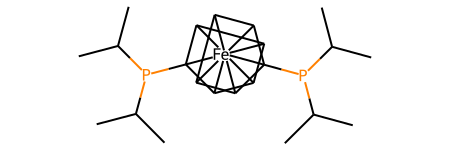

In [83]:
smi = 'CC(C)P(C(C)C)C1%10(C4C2C3C1[Fe]2345679%10C8C5C6C7(P(C(C)C)C(C)C)C89)'
Chem.MolFromSmiles(smi)

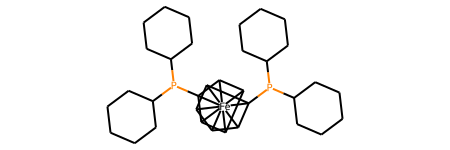

In [64]:
smi= 'C1CCCCC1P(C1CCCCC1)C34C5[Fe]3678912(C5C6C74)C3C8C9C1(C23)P(C1CCCCC1)C1CCCCC1'
Chem.MolFromSmiles(smi)

# Initialize the molecules and generate conformations
We will use some for loops to loop over the smiles, only one conformation will be taken for each molecules in this work

In [84]:
mols = []
for smile in [smi]:
    mols.append(molecule(smile, max_num_conformers=1))

INFO:aqc_utils.molecule:Initializing molecule with canonical smiles: CC(P(C12C3[Fe]4567892(C1C5C34)C1C6C7C9(C81)P(C(C)C)C(C)C)C(C)C)C
INFO:aqc_utils.molecule:Creating initial geometry with option 'best'.
INFO:aqc_utils.molecule:Initial geometry created successfully.


###### Draw some molecules

In [85]:
#mols[0].draw(0)

# Create gaussian job for each conformation

In [86]:
for mol in mols:
    sm.create_jobs_for_molecule(mol, workflow_type="equilibrium")

INFO:aqc_utils.gaussian_input_generator:Generating Gaussian input files for 1 conformations.


C22H36FeP2_5016_conf_0


In [89]:
sm.get_job_stats(split_by_can=True)

status,done,failed,incomplete,submitted,uploaded
can,,,,,
BrB(Br)Br,0,0,0,0,1
Br[Mg]C1CCCCC1,0,0,0,0,1
Br[Mg]Cc1ccccc1,0,0,0,0,1
Br[Mg]c1c(C)cc(cc1C)C,0,0,1,0,0
C(Oc1ccccc1)Oc1ccccc1,0,1,0,0,0
...,...,...,...,...,...
[Sr+2],0,0,0,0,1
[Y+3],0,0,0,0,1
[Zn+2],0,0,0,0,1


In [90]:
sm.submit_jobs()

INFO:aqc_utils.slurm_manager:Submitting 0 jobs.


In [91]:
sm.squeue()

,RUNNING
jobs,6


In [92]:
for job in sm.get_jobs():
    if str(sm.get_jobs()[job].status) == 'slurm_status.done':
        print(sm.get_jobs()[job].base_name)

C20H28O2_1cb0_conf_0


In [93]:
job

'447581cd9c6bf05e9ba87c3a578b7d6d'

In [94]:
job_all = sm.get_jobs()[job]

In [95]:
sm.get_job_stats()

status,done,failed,incomplete,submitted,uploaded
jobs,1,343,3,5,93


In [87]:
str(job_all.status)

'slurm_status.created'

In [88]:
job_all.base_name

'C12H13NO2_b9f2_conf_0'